# Categorical approach

In [1]:
# Libraries
using DataFrames;
using CSV;
using Random;
using Statistics;
using ScikitLearn;
using Flux.Losses;
using Flux;
using Plots;
using StatsPlots;
using Printf;

@sk_import impute: KNNImputer; # Imputation of missing values.
@sk_import svm: SVC;
@sk_import decomposition: PCA;
@sk_import tree: DecisionTreeClassifier;
@sk_import neighbors: KNeighborsClassifier;
@sk_import feature_selection: SelectKBest; # Feature Selection
@sk_import feature_selection: f_classif; # Used with SelectKBest

include("utils/fluxANNs.jl"); # for ANN training with Flux
include("utils/evaluation.jl"); # for confusion matrix calculatestimatorsion and cross validation set partitioning
include("utils/preprocessing.jl"); # for normalization, one-hot encoding, holdout division
include("utils/training.jl"); # for crossvalidation methodology
include("utils/visualizations.jl"); # for plots

# Set seed
Random.seed!(10);

[ Info: Running `conda install -y -c anaconda conda` in root environment


Channels:
 - anaconda
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/marcos/.julia/conda/3/x86_64

  added / updated specs:
    - conda


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2024.8.30~ --> anaconda/linux-64::certifi-2024.8.30-py312h06a4308_0 



Preparing transaction: done
Verifying transaction: done
Executing transaction: done


[ Info: Running `conda install -y -c conda-forge 'libstdcxx-ng>=3.4,<13.0'` in root environment


Channels:
 - conda-forge
 - anaconda
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/marcos/.julia/conda/3/x86_64

  added / updated specs:
    - libstdcxx-ng[version='>=3.4,<13.0']


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            anaconda/linux-64::certifi-2024.8.30-~ --> conda-forge/noarch::certifi-2024.8.30-pyhd8ed1ab_0 



Preparing transaction: done
Verifying transaction: done
Executing transaction: done


# Hold-out partition

In [2]:
# loading the dataset
support2 = CSV.read("datasets/support2_cleaned.csv", DataFrame, delim = ',');

# fate: 0 = recovery, 1 = death at home, 2 = death at the hospital
support2[:, "fate"] = support2[:,"death"] + support2[:,"hospdead"];
target_cols = ["death", "hospdead", "fate"];

trainIndex, testIndex = holdOut(nrow(support2), 0.2);

trainInputs = Array(support2[trainIndex, Not(target_cols)]);
testInputs = Array(support2[testIndex, Not(target_cols)]);

trainTargets = Array(support2[trainIndex, "fate"]);
testTargets = Array(support2[testIndex, "fate"]);

# Kfold
kFoldIndices = crossvalidation(trainTargets, 5);

# Imputation

In [3]:
imputer = KNNImputer(n_neighbors = 5);

trainInputs[:,1:32] = fit_transform!(imputer, trainInputs[:,1:32]);
testInputs[:,1:32] = imputer.transform(testInputs[:,1:32]);

# Visualizations

In [4]:
meanTrain, stdTrain = calculateZeroMeanNormalizationParameters(trainInputs[:,1:32]);
numInputs = normalizeZeroMean!(trainInputs[:,1:32], (meanTrain, stdTrain));

plot_correlations(numInputs);
savefig("plots/correlations.png");

# Train PCA on training dataset.
pca = PCA(2);
pcaInputs = fit_transform!(pca, numInputs);

# Draw results
draw_results(pcaInputs, trainTargets; colors=[:green,:red], target_names=["Survived", "Died"]);
savefig("plots/pca.png");

- ANN

In [5]:
ANNparams = [Dict("topology" => [2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [2, 2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4, 4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8, 8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16, 16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1)]

models = [(:ANN, ANNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training ANN models:
Configuration 1: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [2], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(10 => 2, σ)   # 22 parameters
│   summary(x) = "10×5202 adjoint(::Matrix{Float64}) with eltype Float64"
└ @ Flux ~/.julia/packages/Flux/hiqg1/src/layers/stateless.jl:60


Accuracy:0.8083963284463966 (80.84%), stdDev:0.014199102550692259 (1.42%)
F1-Score:0.8060711925118152 (80.61%), stdDev:0.014263505900807756 (1.43%)

Configuration 2: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [4], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8072614280229342 (80.73%), stdDev:0.014997643381784597 (1.50%)
F1-Score:0.8057108790043583 (80.57%), stdDev:0.015025052827598532 (1.50%)

Configuration 3: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [8], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8080780276597862 (80.81%), stdDev:0.01384350468972902 (1.38%)
F1-Score:0.8065997317745985 (80.66%), stdDev:0.014030811344058293 (1.40%)

Configuration 4: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [16], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8100842593027506 (81.01%), stdDev:0.01342669367042

- SVM

In [6]:
SVMparams = [Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 1)]

models = [(:SVM, SVMparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training SVM models:
Configuration 1: Dict{String, Any}("C" => 0.1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8061121318164328 (80.61%), stdDev:0.01242686614476141 (1.24%)
F1-Score:0.8058354327643616 (80.58%), stdDev:0.012548031988736738 (1.25%)

Configuration 2: Dict{String, Any}("C" => 1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8121999918149132 (81.22%), stdDev:0.015227179373101543 (1.52%)
F1-Score:0.8120205744345836 (81.20%), stdDev:0.01525357383567451 (1.53%)

Configuration 3: Dict{String, Any}("C" => 0.1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.7986389431125472 (79.86%), stdDev:0.011458629874001158 (1.15%)
F1-Score:0.7978785725067742 (79.79%), stdDev:0.011461499893315677 (1.15%)

Configuration 4: Dict{String, Any}("C" => 1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.8073579025401172 (80.74%), stdDev:0.013089121025221535 (1.31%)
F1-Score:0.8059175344007409 (80.59%), stdDev:0.013385

- DecisionTree

In [7]:
DTreeParams = [Dict("maxDepth" => 4), Dict("maxDepth" => 8), Dict("maxDepth" => 16),
                Dict("maxDepth" => 32), Dict("maxDepth" => 64), Dict("maxDepth" => 128)]

models = [(:DTree, DTreeParams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training DTree models:
Configuration 1: Dict("maxDepth" => 4)
Accuracy:0.8242464992017021 (82.42%), stdDev:0.009680393253705498 (0.97%)
F1-Score:0.8201326352040036 (82.01%), stdDev:0.0111022120671285 (1.11%)

Configuration 2: Dict("maxDepth" => 8)
Accuracy:0.8162201564003817 (81.62%), stdDev:0.01619230083778309 (1.62%)
F1-Score:0.8140456692281607 (81.40%), stdDev:0.01700940116864918 (1.70%)

Configuration 3: Dict("maxDepth" => 16)
Accuracy:0.7867413807053378 (78.67%), stdDev:0.011785139499927147 (1.18%)
F1-Score:0.7867250951928486 (78.67%), stdDev:0.01148928010159594 (1.15%)

Configuration 4: Dict("maxDepth" => 32)
Accuracy:0.7809295715714306 (78.09%), stdDev:0.009554228103285302 (0.96%)
F1-Score:0.7809656171584581 (78.10%), stdDev:0.009494150244711442 (0.95%)

Configuration 5: Dict("maxDepth" => 64)
Accuracy:0.7809295715714306 (78.09%), stdDev:0.009554228103285302 (0.96%)
F1-Score:0.7809656171584581 (78.10%), stdDev:0.009494150244711442 (0.95%)

Configuration 6: Dict("maxDepth" => 12

- KNN

In [8]:
KNNparams = [Dict("k" => 3), Dict("k" => 6), Dict("k" => 12),
            Dict("k" => 24), Dict("k" => 48), Dict("k" => 96)]

models = [(:KNN, KNNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");

println(params);


Training KNN models:
Configuration 1: Dict("k" => 3)
Accuracy:0.7675055887344995 (76.75%), stdDev:0.017544684925476884 (1.75%)
F1-Score:0.7666030787135351 (76.66%), stdDev:0.017682985853871534 (1.77%)

Configuration 2: Dict("k" => 6)
Accuracy:0.7872953000169017 (78.73%), stdDev:0.011411894739570197 (1.14%)
F1-Score:0.7862048793141947 (78.62%), stdDev:0.011385734127817657 (1.14%)

Configuration 3: Dict("k" => 12)
Accuracy:0.789231197769446 (78.92%), stdDev:0.010935732595464044 (1.09%)
F1-Score:0.787848939956688 (78.78%), stdDev:0.011243929454209866 (1.12%)

Configuration 4: Dict("k" => 24)
Accuracy:0.7914439116006926 (79.14%), stdDev:0.01244331114873614 (1.24%)
F1-Score:0.7902821713728287 (79.03%), stdDev:0.012664015543440859 (1.27%)

Configuration 5: Dict("k" => 48)
Accuracy:0.7925498381165117 (79.25%), stdDev:0.011568740439323126 (1.16%)
F1-Score:0.7915687715759092 (79.16%), stdDev:0.011615510547586432 (1.16%)

Configuration 6: Dict("k" => 96)
Accuracy:0.7889509343825305 (78.90%), st

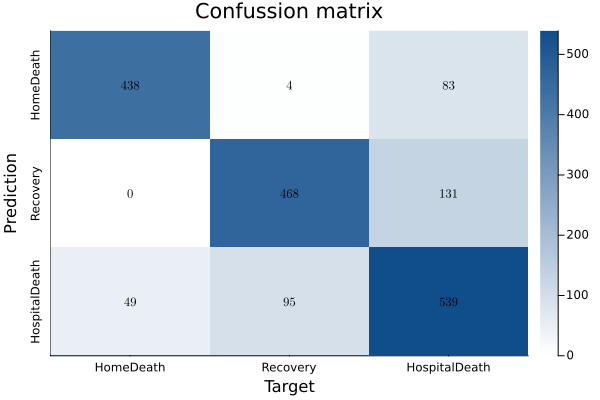

In [9]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# normalization and validation set computation if needed
valRatio = if modelType != :ANN 0. else params["validationRatio"] end
train, val, test = prepareDataForFitting(train, test, valRatio)

classes = unique(trainTargets)
matAndMetrics = fitAndConfusion(modelType, params, train, val, test, classes)
confMat = matAndMetrics[8]

class_map = Dict(0 => "Recovery", 1 => "HomeDeath", 2 => "HospitalDeath")
classNames = [class_map[class] for class in classes]
displayConfMat(confMat, classNames)

- Ensemble

In [10]:
@sk_import ensemble:StackingClassifier

# An ANN flux model cannot be included in a Scikit ensemble due to PyCall wrapping issues
estimators = [:KNN, :DTree, :SVM]
params = []
DTreeParams = Dict("maxDepth" => 4)
KNNparams = Dict("k" => 24)
SVMparams = Dict("C" => 1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)


params = Vector{Dict}([KNNparams, DTreeParams, SVMparams])

printCrossValOutput(trainClassEnsemble(estimators, params, (trainInputs, trainTargets),
                   crossvalidation(trainTargets, 5)));

Accuracy:0.832274566121136 (83.23%), stdDev:0.008008447252839182 (0.80%)
F1-Score:0.8287509458503589 (82.88%), stdDev:0.007993522523575427 (0.80%)



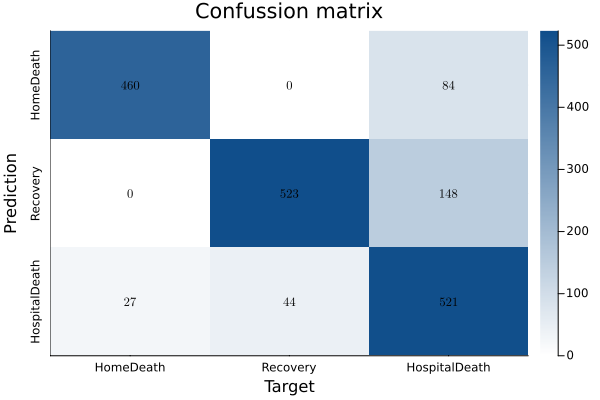

In [11]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# standardization is applied
trainNorm, _, testNorm = prepareDataForFitting(train, test)
ensemble = fitEnsemble(trainNorm, estimators, params)

classes = unique(trainTargets)
matAndMetrics = confusionMatrix(predict(ensemble, testNorm[1]), testTargets; weighted=true)
confMat = matAndMetrics[8]

class_map = Dict(0 => "Recovery", 1 => "HomeDeath", 2 => "HospitalDeath")
classNames = [class_map[class] for class in classes]
displayConfMat(confMat, classNames)